# Backpropagation Lab





In [21]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
import time

from scipy.io.arff import loadarff
import pandas as pd

np.set_printoptions(precision=10)


## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e., do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [150]:
class MLP(BaseEstimator,ClassifierMixin):
    
    def __init__(self,lr=.1, momentum=0, shuffle=True, hidden_layer_widths=None, zeros=False, output_layer=[1], stopping_condition="both", stopping_threshold=0.001, validation_size=0.15):
        """ Initialize class with chosen hyperparameters.

        Args:
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent 
        Optional Args (Args we think will make your life easier):
            hidden_layer_widths (list(int)): A list of integers which defines the width of each hidden layer if hidden layer is none do twice as many hidden nodes as input nodes. (and then one more for the bias node)
            For example: input width 1, then hidden layer will be 3 nodes
        Example:
            mlp = MLP(lr=.2,momentum=.5,shuffle=False,hidden_layer_widths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.hidden_layer_widths = hidden_layer_widths
        self.zeros = zeros
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.output_layer = output_layer
        self.stopping_threshold = stopping_threshold
        self.mses_val = []
        self.mses_train = []
        self.accuracies_val = []
        self.accuracies_train = []
        self.validation_size = validation_size
        self.stopping_condition = stopping_condition


    def fit(self, X, y, initial_weights=None, printing=False, epochs=None):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        # initialize the weights
        #self.zeros = zeros
        self.initial_weights = initial_weights
        self.weights, self.outputs, self.nets, errors_0, weights_0 = self.initialize_weights(
            len(X[0]), len(y[0]))
        zeros = self.zeros
        
        # get local version of the class variables
        weights = deepcopy(self.weights)
        lr = self.lr
        momentum = self.momentum
        validation_size = self.validation_size
        
        epoch_count = 0
        self.mses = []
        epochs_since = 0
        best_mse = np.inf
        
        new_weights = deepcopy(weights)
        prev_deltas = deepcopy(weights_0)
        nets = deepcopy(self.nets)
        outputs = deepcopy(self.outputs)
        errors = deepcopy(errors_0)
        
        if validation_size > 0:
            X, X_val, y, y_val = train_test_split(X, y, test_size=validation_size)
        else:
            X_val = deepcopy(X)
            y_val = deepcopy(y)
            
        if len(y.shape) == 1:
            y = np.expand_dims(y, axis=1)
        if len(y_val.shape) == 1:
            y_val = np.expand_dims(y_val, axis=1)
        
        # keep running epochs, at the end there are if statements
        # that break out of this while loop
        while True:
            
            if printing:
                print("---Epoch {}---".format(epoch_count+1))
                
            if printing:
                print("Initial Weights:")
                for w in weights:
                    print(w)
                print()
                print("Initial errors:")
                for e in errors:
                    print(e)
                print()
                print("Initial outputs:")
                for o in outputs:
                    print(o)
                print()
            
            if self.shuffle:
                X, y = self._shuffle_data(X, y)
                
            # iterate over each input
            for x, input_ in enumerate(X):
                target_ = y[x]
                
                weights = deepcopy(new_weights)
                
                if printing:
                    '''
                    print("Weights:")
                    for w in weights:
                        print(w)
                    '''
                    print("Input vector: {}".format(input_))
                    print("Target output: {}".format(target_))
                    print("Forward propagating...")
                
                # run calculations for each node from the input
                in_ = input_
                for i, layer in enumerate(weights):
                    in_ = np.insert(in_, 0, 1)
                    for j, node in enumerate(layer):
                        val = np.dot(in_, node)
                        #print("Calc {}:\n{} x {} = {}\n".format(str(i)+str(j), in_str, weights_str, val_str))
                        #print("Calc {}:\n{} x {} = {}".format(str(i)+str(j), in_, weights[i][j], val))
                        
                        nets[i][j] = val
                        outputs[i][j] = self._sigmoid(val)[0]
                    in_ = outputs[i]
                    
                if printing:
                    '''
                    print("Nets:")
                    for n in nets:
                        print(n)
                    '''
                    print("Outputs:")
                    for o in outputs:
                        print(o)
                    
                if printing:
                    print("Predicted output: {}".format(outputs[-1]))
                    print("Back propagating...")
                
                # initialize the errors and flip the NN to be a feedbackward
                errors = errors[::-1]
                nets = nets[::-1]
                outputs = outputs[::-1]
                weights = weights[::-1]

                def d_output(T, Z):
                    return (T - Z) * Z * (1 - Z)

                in_ = d_output(target_, outputs[0])
                errors[0] = in_
                for i, layer in enumerate(weights):
                    if i == 0:
                        continue
                    for j, node in enumerate(layer):
                        w = weights[i-1][:,j+1]
                        val = np.dot(in_, w) * outputs[i][j] * (1 - outputs[i][j])
                        #print("Calc {}:\n{} x {} = {}\n".format(str(i)+str(j), in_str, w_str, val_str))
                        #print("Calc {}:\n{} x {} = {}\n".format(str(i)+str(j), in_, w, val))
                        errors[i][j] = val
                    in_ = errors[i]

                errors = errors[::-1]
                nets = nets[::-1]
                outputs = outputs[::-1]
                weights = weights[::-1]
                if printing:
                    print("Error Values:")
                    for d in errors:
                        print(d)
                #weights = weights + errors
                #print("Weights:\n{}".format(weights))

                in_ = input_
                for i, layer in enumerate(weights):
                    in_ = np.insert(in_, 0, 1)
                    for j, node in enumerate(layer):
                        prev_delta = prev_deltas[i][j]
                        delta_weight = (lr*errors[i][j]*in_) + momentum*prev_delta
                        #print("new_weight: {} + {} + {} * {}".format(node, delta_weight, momentum, prev_delta))
                        new_weights[i][j] = node + delta_weight
                        prev_deltas[i][j] = delta_weight

                    in_ = np.array(outputs[i])
                if printing:
                    print("Updated weights:")
                    for w in new_weights:
                        print(w)
            

            curr_mse = self._mse(X_val, y_val, weights=new_weights, printing=printing)
            if printing:
                print("MSE: {}".format(curr_mse))
            self.mses_val.append(curr_mse)
            curr_mse_train = self._mse(X, y, weights=new_weights, printing=printing)
            self.mses_train.append(curr_mse_train)
            curr_acc_test = self.score(X_val, y_val, weights=new_weights, printing=printing)
            self.accuracies_val.append(curr_acc_test)
            curr_acc_train = self.score(X, y, weights=new_weights, printing=printing)
            self.accuracies_train.append(curr_acc_train)
            backup_weights = None
           
            epoch_count += 1
            if type(epochs) == type(None):
                
                if epoch_count > 10:
                    if self.stopping_condition == "variance":
                        prev = np.array(self.mses_val[-7:-1])
                        curr = np.array([curr_mse for _ in range(len(prev))])
                        result = np.all(np.abs(prev-curr) < self.stopping_threshold)
                        
                        if result == True:
                            break
                        
                    elif self.stopping_condition == "best_mse":
                        if curr_mse < best_mse:
                            best_mse = curr_mse
                            epochs_since = 0
                        else:
                            epochs_since += 1
                        if epochs_since > 7:
                            break
                        
                    elif self.stopping_condition == "both":
                        prev = np.array(self.mses_val[-7:-1])
                        curr = np.array([curr_mse for _ in range(len(prev))])
                        result = np.all(np.abs(prev-curr) < self.stopping_threshold)
                        
                        if curr_mse < best_mse:
                            best_mse = curr_mse
                            epochs_since = 0
                        else:
                            epochs_since += 1
                        result1 = True if epochs_since > 5 else False
                        
                        if result or result1:
                            break
                        
                    #result = np.abs(prev.max() - prev.min()) < self.stopping_threshold
                if epoch_count > 100:
                    break
            else:
                if epoch_count >= epochs:
                    break
              
        self.weights = deepcopy(new_weights)
        return self
    
    def initialize_weights(self, m, n):
        """ Initialize weights for perceptron. Don't forget the bias!

        Returns:

        """
        input_size = m
        layers = self.hidden_layer_widths
        output_layer = [n]
        zeros = self.zeros
        weights = []
        outputs = []
        nets = []
        initial_weights = self.initial_weights
        
        if type(layers) == type(None):
            print("Created a layer of twice input size ({})".format(input_size*2))
            layers = [input_size*2]

        layers = layers + output_layer

        prev_input_size = input_size  # CHANGE
        for i, layer in enumerate(layers):
            outputs.append([0 for _ in range(layer)])
            weights.append([[0 for _ in range(prev_input_size+1)]
                        for _ in range(layer)])  # CHANGE
            prev_input_size = layer  # CHANGE

        weights_0 = deepcopy(weights)

        total = 0
        for i, layer in enumerate(weights):
            for i, node in enumerate(layer):
                total += len(node)

        if not zeros:
            ran_vals = np.array(np.random.standard_normal(size=(total)))

            if type(initial_weights) != type(None):
                ran_vals = initial_weights

            c = 0
            for i, layer in enumerate(weights):
                for j, node in enumerate(layer):
                    for k in range(len(node)):
                        weights[i][j][k] = ran_vals[c]
                        c += 1

        nets = deepcopy(outputs)
        errors_0 = deepcopy(outputs)

        for i in range(len(weights)):
            weights[i] = np.array(weights[i]).astype(np.float64)
        for i in range(len(weights_0)):
            weights_0[i] = np.array(weights_0[i]).astype(np.float64)
        for i in range(len(nets)):
            nets[i] = np.array(nets[i]).astype(np.float64)
        for i in range(len(outputs)):
            outputs[i] = np.array(outputs[i]).astype(np.float64)
        for i in range(len(errors_0)):
            errors_0[i] = np.array(errors_0[i]).astype(np.float64)

            
        return weights, outputs, nets, errors_0, weights_0
        

    def predict(self, X, weights=None, printing=False):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        if type(weights) == type(None):
            weights = self.weights
        else:
            weights = weights
            
        nets = self.nets
        outputs = self.outputs
        
        output = []
        predictions = []
        for x in X:
            in_ = x
            for i, layer in enumerate(weights):
                in_ = np.insert(in_, 0, 1)
                for j, node in enumerate(layer):
                    val = np.dot(in_, node)
                    #print("Calc {}:\n{} x {} = {}\n".format(str(i)+str(j), in_str, weights_str, val_str))
                    #print("Calc {}:\n{} x {} = {}".format(str(i)+str(j), in_, weights[i][j], val))

                    nets[i][j] = val
                    outputs[i][j] = self._sigmoid(val)[0]
                in_ = deepcopy(outputs[i])
            
            out = deepcopy(outputs[-1])
            if len(out) == 1:
                output.append([val])
                val = 1 if out[0] >= 0.5 else 0
                predictions.append([val])
                if printing:
                    print("Mod-Out: {}  :  Pred-Out: {}".format(out, val))
            else:
                mx = -np.inf
                mx_i = 0
                for i, f in enumerate(out):
                    if f > mx:
                        mx = f
                        mx_i = i
                final = [0 for _ in range(len(out))]
                final[mx_i] = 1
                output.append(out)
                predictions.append(final)
                if printing:
                    print("Mod-Out: {}  :  Pred-Out: {}".format(out, final))
                
        return np.array(predictions), output
                
    def _mse(self, X, y, weights=None, printing=False):
        sse = 0
        
        if type(weights) == type(None):
            output = self.predict(X, printing=printing)[1]
        else:
            output = self.predict(X, weights=weights, printing=printing)[1]
            
        for i, o in enumerate(output):
            if type(o) == type(np.array([])):
                if len(o) == 1:
                    val = (y[i][0] - o[0])**2
                elif len(o) > 1:
                    val = (sum(y[i]) - sum(o))**2
                else:
                    val = (sum(y[i]) - o)**2
            else:
                val = (y[i] - o)**2
            sse += val
        
        return sse/len(y)
            

    def score(self, X, y, weights=None, printing=False):
        """ Return accuracy of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets

        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        # get predications
        if type(weights) == type(None):
            predictions = self.predict(X, printing=printing)[0]
        else:
            predictions = self.predict(X, weights=weights, printing=printing)[0]
        
        # see if predictions are correct
        yes = 0
        no = 0
        for i, p in enumerate(predictions):
            if np.array_equal(p, y[i]):
                yes += 1
            else:
                no += 1
                
        # get percentage of correct preditions out of total predictions
        accuracy = yes / (yes+no)
        if printing:
            print(f"Acc: {round(accuracy,2)}")
            print("Weights:\n")
            weights = self.get_weights()
            for w in weights:
                print(w)
            print()

        return accuracy

    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        # combine
        shape = y.shape
        if len(shape) == 1:
            n = shape[0]
        else:
            n = shape[1]
        combined = np.concatenate((X, y), axis=1)
        # shuffle
        np.random.shuffle(combined)
        # split back into training instances and targets
        X = combined[:, :-n]
        y = combined[:, -n:]
        return X, y
    


    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        ret_weights = deepcopy(self.weights)
        for i in range(len(ret_weights)):
            ret_weights[i] = np.transpose(ret_weights[i])
            indices = [i for i in range(len(ret_weights[i]))]
            indices = indices[1:] + [indices[0]]
            ret_weights[i] = ret_weights[i][indices]
        
        return ret_weights


    def _sigmoid(self, x):
        val = np.around(x, 4)
        return 1/(1+np.exp(-x)), f"1/(1+e^(-{val}))"

## 1.1 

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://byu.instructure.com/courses/14142/files?preview=4421290)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://byu.instructure.com/courses/14142/files?preview=4537323) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://byu.instructure.com/courses/14142/files?preview=4537340) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

In [92]:
# Load debug data
def debug_data():
    # load data from arff
    data = loadarff('debug_dataset.arff')
    df = pd.DataFrame(data[0])

    # convert to utf-8
    new_class = []
    for i, val in enumerate(df["class"]):
        new_class.append(int(val.decode('utf-8')))
    df["class"] = new_class

    # get the input and output arrays
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:, -1].to_numpy()
    
    y_one_hot = []
    for e in y:
        vec = np.array([0,0])
        if e == 0:
            vec[0] = 1
        else:
            vec[1] = 1
        y_one_hot.append(vec)
    y_one_hot = np.array(y_one_hot)

    return df, X, y, y_one_hot

#load debug data
df, X, y, y_one_hot = debug_data()
nn = MLP(lr=0.1, momentum=0.5, shuffle=False,
         hidden_layer_widths=[4], output_layer=[1], zeros=True, validation_size=0)

# Train on debug data
nn.fit(X, y, printing=False, epochs=10)

# print weights
weights = nn.get_weights()
for w in weights:
    print(w)
    
print(len(nn.mses))
    

nn = MLP(lr=0.1, momentum=0.5, shuffle=False,
         hidden_layer_widths=[4], output_layer=[2], zeros=True, validation_size=0)

# Train on debug data
nn.fit(X, y_one_hot, printing=False, epochs=10)

# print weights
weights = nn.get_weights()
for w in weights:
    print(w)
    
print(len(nn.mses))



[[-8.8177979727e-05 -8.8177979727e-05 -8.8177979727e-05 -8.8177979727e-05]
 [ 7.8275773110e-04  7.8275773110e-04  7.8275773110e-04  7.8275773110e-04]
 [-3.9435364490e-03 -3.9435364490e-03 -3.9435364490e-03 -3.9435364490e-03]]
[[-0.0106088802]
 [-0.0106088802]
 [-0.0106088802]
 [-0.0106088802]
 [-0.0214549535]]
0
[[-0.0001814943 -0.0001814943 -0.0001814943 -0.0001814943]
 [ 0.001574685   0.001574685   0.001574685   0.001574685 ]
 [-0.0078821845 -0.0078821845 -0.0078821845 -0.0078821845]]
[[ 0.0105064172 -0.0105064172]
 [ 0.0105064172 -0.0105064172]
 [ 0.0105064172 -0.0105064172]
 [ 0.0105064172 -0.0105064172]
 [ 0.0214877791 -0.0214877791]]
0


### 1.1.2 Evaluation

Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

We will evaluate your model based on printed weights after training on the [Evaluation Dataset](https://byu.instructure.com/courses/14142/files?preview=4421294)

In [91]:
# Load evaluation data
def evaluation_data():
    # load data from arff
    data = loadarff('evaluation_dataset.arff')
    df = pd.DataFrame(data[0])

    # convert to utf-8
    new_class = []
    for i, val in enumerate(df["class"]):
        new_class.append(int(val.decode('utf-8')))
    df["class"] = new_class

    # get the input and output arrays
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:, -1].to_numpy()
    
    y_one_hot = []
    for e in y:
        vec = np.array([0,0])
        if e == 0:
            vec[0] = 1
        else:
            vec[1] = 1
        y_one_hot.append(vec)
    y_one_hot = np.array(y_one_hot)

    return df, X, y, y_one_hot

#load debug data
df, X, y, y_one_hot = evaluation_data()
nn = MLP(lr=0.1, momentum=0.5, shuffle=False,
         hidden_layer_widths=[4], output_layer=[2], zeros=True, validation_size=0)

# Train on debug data
nn.fit(X, y, printing=False, epochs=10)

# print weights
weights = nn.get_weights()
for w in weights:
    print(w)



[[ 1.6382872051  1.6382872051  1.6382872051  1.6382872051]
 [ 1.0961224949  1.0961224949  1.0961224949  1.0961224949]
 [ 1.2344759399  1.2344759399  1.2344759399  1.2344759399]
 [ 0.3926948683  0.3926948683  0.3926948683  0.3926948683]
 [-2.0931615103 -2.0931615103 -2.0931615103 -2.0931615103]]
[[-1.8169561137 -1.8169561137]
 [-1.8169561137 -1.8169561137]
 [-1.8169561137 -1.8169561137]
 [-1.8169561137 -1.8169561137]
 [ 4.1709807116  4.1709807116]]


## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://byu.instructure.com/courses/14142/files?preview=4421369)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

Created a layer of twice input size (8)


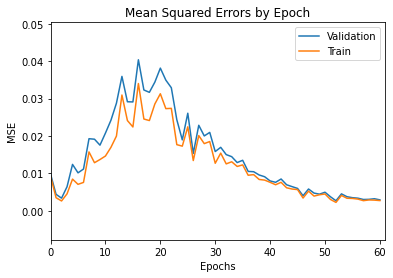

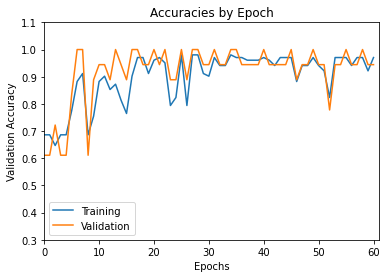

Model Accuracy: 0.9666666666666667


In [107]:
def iris_data():
    # load data from arff
    data = loadarff('iris.arff')
    df = pd.DataFrame(data[0])

    # convert to utf-8
    new_class = []
    for i, val in enumerate(df["class"]):
        new_class.append(val.strip().decode('utf-8'))
    df["class"] = new_class

    # get the input and output arrays
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:, -1].to_numpy()

    y_one_hot = []
    for e in y:
        vec = np.array([0, 0, 0])
        if e == "Iris-setosa":
            vec[0] = 1
        elif e == "Iris-versicolor":
            vec[1] = 1
        elif e == "Iris-virginica":
            vec[2] = 1
        else:
            raise ValueError(
                f"Not one of the flower classes with '{e}' as the class name")
        y_one_hot.append(vec)
    y_one_hot = np.array(y_one_hot)
    y = deepcopy(y_one_hot)

    return df, X, y

def run_iris():
    #load debug data
    df, X, y = iris_data()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=42, test_size=0.2)
    nn = MLP(lr=0.1, momentum=0.2, shuffle=True, output_layer=[3], zeros=False)

    # Train on debug data
    nn.fit(X_train, y_train, printing=False)

    acc = nn.score(X_test, y_test, printing=False)
    
    plt.title("Mean Squared Errors by Epoch")
    plt.plot([i for i in range(len(nn.mses_val))], nn.mses_val, label="Validation")
    plt.xlim(0, len(nn.mses_val))
    upper = max(max(nn.mses_val), max(nn.mses_train))+0.01
    lower = min(min(nn.mses_val), min(nn.mses_train))-0.01
    plt.ylim(lower, upper)
    
    plt.plot([i for i in range(len(nn.mses_train))],
             nn.mses_train, label="Train")
    plt.xlim(0, len(nn.mses_train))
    plt.ylim(lower, upper)
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

    plt.title("Accuracies by Epoch")
    plt.plot([i for i in range(len(nn.accuracies_train))], nn.accuracies_train, label="Training")
    plt.xlim(0, len(nn.accuracies_train))
    plt.ylim(0.3, 1.1)
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")

    plt.plot([i for i in range(len(nn.accuracies_val))], nn.accuracies_val, label="Validation")
    plt.xlim(0, len(nn.accuracies_val))
    plt.ylim(0.3, 1.1)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.show()
    
    print("Model Accuracy: {}".format(acc))


#run_example_2()
run_iris()


## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://byu.instructure.com/courses/14142/files?preview=4537354)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 80/20 splits of the data for the training/test set.
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn. 

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

In [87]:
# Train on each dataset
def one_hot(classes, item):
    trans = {}
    for i, c in enumerate(classes):
        trans[c] = i
    vec = np.array([0 for _ in range(len(classes))])
    vec[trans[item]] = 1
    return vec, trans[item]

def vowel_data():
    # load data from arff
    data = loadarff('vowel.arff')
    df = pd.DataFrame(data[0])
    df = df.iloc[:,3:] # get rid of Train/Test, speaker and gender columns
    
    classes = {"Train or Test":["Train", "Test"],
               "Speaker Number": ["Andrew", "Bill", "David", "Mark", 
                                  "Jo", "Kate", "Penny", "Rose", 
                                  "Mike", "Nick", "Rich", "Tim", 
                                  "Sarah", "Sue", "Wendy"],
               "Sex":["Male","Female"],
               "Class": ["hid", "hId", "hEd", "hAd", "hYd", "had", "hOd", "hod", "hUd", "hud", "hed"]}

    # convert to utf-8
    new_class = []
    for c in df.columns:
        if c in classes:
            new_class = []
            for i, val in enumerate(df[c]):
                new_class.append(one_hot(classes[c], val.strip().decode('utf-8'))[1])
            df[c] = new_class
        

    # get the input and output arrays
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:, -1].to_numpy()

    y_one_hot = []
    for e in y:
        vec = [0 for _ in range(len(classes["Class"]))]
        vec[e] = 1
        y_one_hot.append(vec)
    y_one_hot = np.array(y_one_hot)
    y = deepcopy(y_one_hot)

    return df, X, y



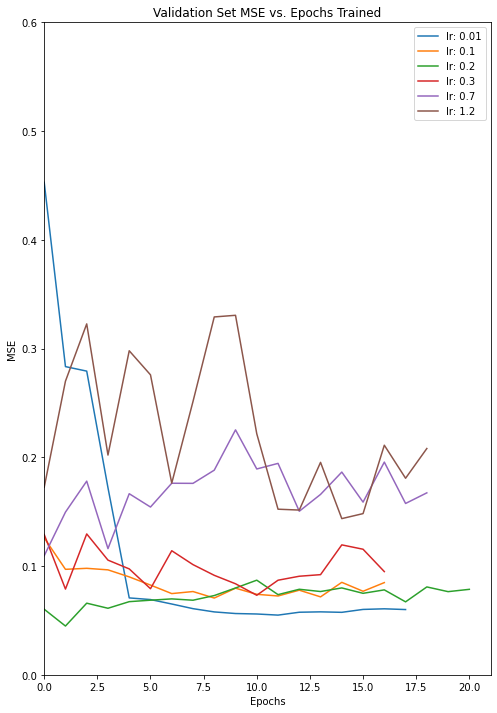

In [216]:
df, X, y = vowel_data()
def generate_lr_df():
    lrs = [0.001, 0.01, 0.1, 0.2, 0.3, 0.7, 1.2]
    df_lrs = pd.DataFrame()
    #lrs = [0.2]
    max_x = 0
    min_y = np.inf
    max_y = 0
    plt.figure(figsize=(8, 12))
    plt.title("Validation Set MSE vs. Epochs Trained")
    for i, l in enumerate(lrs):
        xs = []
        ys = []
        for j in range(3):
            print("Starting lr {} ...".format(l))
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, random_state=42, test_size=0.2)
            nn = MLP(lr=l, momentum=0.5, shuffle=True, hidden_layer_widths=[len(X[0])*2], output_layer=[len(y[0])],
                    zeros=False, validation_size=0.15, stopping_threshold=0.001, stopping_condition="both")
            # Train on debug data
            nn.fit(X_train, y_train, printing=False)
            acc = nn.score(X_test, y_test, printing=False)
            data_y = nn.mses_val
            data_x = [i for i in range(len(data_y))]
            xs.append(data_x)
            ys.append(data_y)

        sizes = [len(item) for item in ys]
        n = min(sizes)
        avg_y = []
        for j in range(n):
            val = ys[0][j] + ys[1][j] + ys[2][j]
            val /= 3
            avg_y.append(val)
        curr_avg_y = pd.DataFrame({str(l): avg_y})
        df_lrs = pd.concat([df_lrs, curr_avg_y], axis=1)
        
df_lrs = pd.read_csv("learning_rates.csv")
df_lrs = df_lrs.iloc[:,1:]
df_lrs

mx_x = 0
plt.figure(figsize=(8, 12))
plt.title("Validation Set MSE vs. Epochs Trained")
for col in df_lrs.columns:
    data = list(df_lrs[col])
    x = [i for i in range(len(data))]
    mx_x = max(len(x), mx_x)
    plt.plot(x, data, label=str(f"lr: {col}"))
    
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.xlim(0, mx_x)
plt.ylim(0, 0.6)
plt.legend()
plt.show()


## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates. 
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies. 
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, ect) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.



In [86]:
accuracies = []
epochs = []

#load debug data
df, X, y = iris_data()
for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    nn = MLP(lr=0.1, momentum=0.2, validation_size=0.15,
             shuffle=True, hidden_layer_widths=[len(X[0])*2], output_layer=[len(y[0])], zeros=False)
    # Train on debug data
    nn.fit(X_train, y_train, printing=False)
    acc = nn.score(X_test, y_test, printing=False)
    accuracies.append(acc)
    epochs.append(len(nn.mses_val))

dictionary = {"Accuracies": accuracies, "Epochs": epochs}
df = pd.DataFrame(data=dictionary)
print("Iris Test Accuracies")
display(df)

accuracies = []
epochs = []

#load debug data
df, X, y = vowel_data()
for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    nn = MLP(lr=0.1, momentum=0.2, shuffle=True, hidden_layer_widths=[len(X[0])*2], output_layer=[len(y[0])],
             zeros=False, validation_size=0.15, stopping_threshold=0.01, stopping_condition="both")
    # Train on debug data
    nn.fit(X_train, y_train, printing=False)
    acc = nn.score(X_test, y_test, printing=False)
    accuracies.append(acc)
    epochs.append(len(nn.mses_val))

dictionary = {"Accuracies": accuracies, "Epochs": epochs}
df = pd.DataFrame(data=dictionary)
print("Vowel Test Accuracies")
display(df)



Iris Test Accuracies


,Accuracies,Epochs
0,0.966667,101
1,0.900000,49
2,0.933333,42
3,0.800000,27
4,1.000000,31
5,1.000000,53
6,0.833333,18
7,0.933333,37
8,0.933333,36
9,0.233333,11


Vowel Test Accuracies


,Accuracies,Epochs
0,0.535354,18
1,0.404040,15
2,0.545455,17
3,0.500000,17
4,0.388889,11
5,0.545455,19
6,0.535354,18
7,0.580808,26
8,0.590909,20
9,0.510101,20


In [219]:
accuracies = pd.read_csv("learning_rate_acc.csv").iloc[:, 1:]
accuracies


,0.01,0.1,0.2,0.3,0.7,1.2
0,0.351852,0.555556,0.648148,0.575758,0.584175,0.494949



**Learning Rate Analysis:** From the accuracy chart, it is apparent that my model generally performed best with a learning rate around 0.2, with 0.2 demonstrating the strongest accuracies.

From the graph showing the validation MSE, it is notable how the different learning rates affect the behavior of the change in validation MSE. When the model has a higher learning rate, it appears that the validation MSE tends to fluctuate a lot more. The purple and brown lines (lr=0.7 and lr=1.2) make jumps up to a full 0.1 different from the previous iteration.

Smaller learning rates tend to have a more gradual change in the validation MSE. This is definitely a more desirable quality since this causes the model to gradually make precise changes to the weights until it arrives at a strong result. The best performing learning rates were the ones that followed a more gradual trend, and also reached a lower validation MSE. lr=0.01 and lr=0.2 tended to follow these two requirements.

**Stopping Criteria:** I would also like to point out, that this graph would likely appear much different with a different stopping criteria. I set the stopping criteria to stop after the model has not found a lower validation MSE for 7 epochs. I first implemented a stopping-criteria that checked if the validation MSE has not changed more than 0.01 over the past five iterations, but this stopping criteria would not work when the learning rate was set very high, since the validation mse tended to fluctuate between large values. 

**Vowel Data Set Difficulty:** The vowel set data has a much larger input size, so the multi-layer perceptron takes longer to run. It also has a much larger amount of classes to choose from, so the model would need to train for a longer period of time to adjust to all of the different variations of outputs. This also increases the amount of computations that need to occur, since the mean-squared-error calculations and error calculations all have a much larger degree of variation.

  * From the above dataframes, I have shown the accuracy that my model achieves on the Iris and Vowel datatsets by running each of them a few times. As you can see from the displayed charts, the Iris dataset definitely caused higher model performance in relation to accuracy. The best was around 97% and on a few odd instances even achieved 100%. It's baseline average performance tended to be in the high 90s. The Vowel data set test accuracies were definitely much lower with a high of 59% and a general baseline average of around 51%.


**Vowel Dataset Inputs:** For training my model, I decided to drop the `Train/Test` column and `speaker` columns. I dropped the Train/Test column since in the original study, they used these labels to differentiate between their training and testing instances. For my purpose, I divide the data with an 80/20 split, so the Train/Test column has no relevance to this purpose. Since the study basically just had different individuals come in as subjects for their study, each individual's name should not be considered as a notable feature, since their name has no relation to how they speak. The features themselves should be the only indicator of speech patterns. I also removed the gender column since the features in the data generally tended to be decimal values fluctuating between negative and positive values


## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

In [146]:
def nodes_test():
    df, X, y = vowel_data()

    accuracies = []
    epochs = []
    nodes = []
    val_mses = []
    train_mses = []
    node = 1
    time_to_break = 3
    while True:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        nn = MLP(lr=0.1, momentum=0.5, shuffle=True, hidden_layer_widths=[node], output_layer=[len(y[0])],
                zeros=False, validation_size=0.15, stopping_threshold=0.001, stopping_condition="both")
        # Train on debug data
        nn.fit(X_train, y_train, printing=False)
        acc = nn.score(X_test, y_test, printing=False)
        
        accuracies.append(acc)
        epochs.append(len(nn.mses_val))
        nodes.append(node)
        val_mses.append(max(nn.mses_val))
        train_mses.append(max(nn.mses_train))
        
        node *= 2
        print(node)
        print(acc)
        print(len(nn.mses_val))
        
        if len(accuracies[:-1]) > 4 and acc < min(accuracies[-4:-1]):
            time_to_break -= 1
            
        if time_to_break <= 0:
            break

    dictionary = {"Test Accuracies": accuracies, "Epochs": epochs, "Nodes":nodes, "Validation MSE":val_mses, "Training MSE":train_mses}
    df = pd.DataFrame(data=dictionary)
    print("Vowel Test Accuracies")
    display(df)

df_nodes = pd.read_csv("nodes.csv")
df_nodes = df_nodes.iloc[:,1:]
df_nodes


,Test Accuracies,Epochs,Nodes,Validation MSE,Training MSE
0,0.136364,17,1,0.056102,0.056039
1,0.070707,11,2,0.003395,0.003161
2,0.429293,17,4,0.074758,0.086896
3,0.383838,17,8,0.229630,0.181194
4,0.439394,20,16,0.120098,0.097506
5,0.636364,25,32,0.388178,0.382802
6,0.510101,17,64,0.465682,0.437009
7,0.464646,21,128,0.724812,0.745508
8,0.373737,29,256,1.431212,1.444203
9,0.222222,23,512,0.997564,0.996834


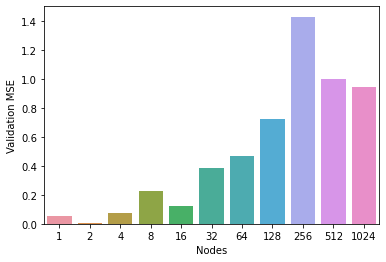

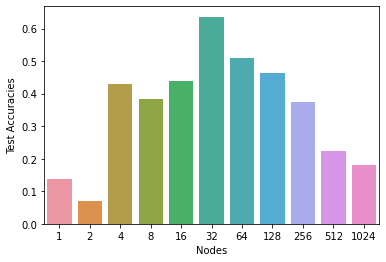

In [148]:

sns.barplot(data=df_nodes, x="Nodes", y="Validation MSE")
plt.show()

sns.barplot(data=df_nodes, x="Nodes", y="Test Accuracies")
plt.show()


**Node effect of Validation MSE:** It appears that there is a very consistent positive trend between number of nodes and the validation MSE. As the node count increases the Validation MSE also increases. This is a reasonable trend, since there will be more error as you introduce more nodes into the model. 

**Node effect on Accuracy:** This graph follows a very distinct bell-curve where 32 nodes seems to give the best accuracy, while node counts of 1, 2, 512 or 1024 tend to decrease the accuracy. This is a reasonable conclusion since there is an ideal number of nodes per problem. Ideally there will be enough nodes to allow the model to pick up on the nuances in the input data, but at the same time to have a small enough number of nodes so the model does not hyper-specify regarding the inputs.



## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- For each momentum term, print the test set accuracy. 
- You are trying to see how much momentum speeds up learning and how it affects accuracy.

In [123]:
def momentum_test():
    df, X, y = vowel_data()

    accuracies = []
    epochs = []
    momentums = []
    val_mses = []
    train_mses = []
    momentum = 0.1
    time_to_break = 3
    while True:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        nn = MLP(lr=0.1, momentum=momentum, shuffle=True, hidden_layer_widths=[len(X[0])*2], output_layer=[len(y[0])],
                zeros=False, validation_size=0.15, stopping_threshold=0.001, stopping_condition="both")
        # Train on debug data
        nn.fit(X_train, y_train, printing=False)
        acc = nn.score(X_test, y_test, printing=False)
        
        accuracies.append(acc)
        epochs.append(len(nn.mses_val))
        momentums.append(momentum)
        val_mses.append(max(nn.mses_val))
        train_mses.append(max(nn.mses_train))
        
        print(momentum)
        print(acc)
        print(len(nn.mses_val))

        momentum += 0.1
        
        if len(accuracies[:-1]) > 3 and acc < min(accuracies[-3:-1]):
            time_to_break -= 1
            
        if time_to_break <= 0:
            break

    dictionary = {"Test Accuracies": accuracies, "Epochs": epochs, "Momentums":momentums, "Validation MSE":val_mses, "Training MSE":train_mses}
    df = pd.DataFrame(data=dictionary)
    print("Vowel Test Accuracies")
    display(df)
    
df_momentum = pd.read_csv("momentums.csv")
df_momentum = df_momentum.iloc[:11,:]
df_momentum["Momentums"] = df_momentum["Momentums"].round(1)
df_momentum



,Unnamed: 0,Test Accuracies,Epochs,Momentums,Validation MSE,Training MSE
0,0,0.459596,17,0.1,0.137028,0.148871
1,1,0.535354,17,0.2,0.148152,0.155191
2,2,0.545455,17,0.3,0.187345,0.193533
3,3,0.520202,22,0.4,0.171098,0.182243
4,4,0.611111,18,0.5,0.225713,0.214901
5,5,0.565657,17,0.6,0.103057,0.107941
6,6,0.681818,28,0.7,0.144608,0.121807
7,7,0.616162,23,0.8,0.134534,0.120098
8,8,0.611111,17,0.9,0.193779,0.205100
9,9,0.085859,11,1.0,1.000000,1.000000


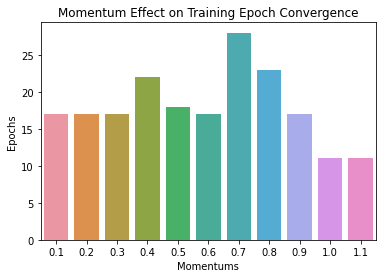

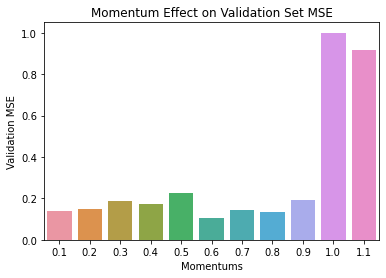

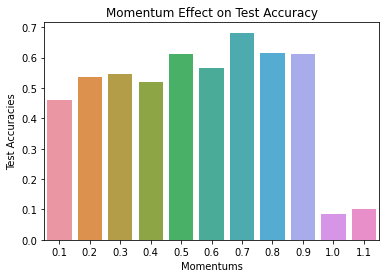

In [134]:
plt.title("Momentum Effect on Training Epoch Convergence")
sns.barplot(data=df_momentum, x="Momentums", y="Epochs")
plt.show()

plt.title("Momentum Effect on Validation Set MSE")
sns.barplot(data=df_momentum, y="Validation MSE", x="Momentums")
plt.show()

plt.title("Momentum Effect on Test Accuracy")
sns.barplot(data=df_momentum, y="Test Accuracies", x="Momentums")
plt.show()


**1.0/1.1 Errors:** All of these plots demonstrate that if the momentum value is equal to 1.0 or greater than 1.0, the Validation MSE and Accuracy rates go down drastically. This shows that we should aim for a momentum value between 0 and 1, which is understandbale when considering the equation.

**Momentum Effect on Training Time:** It would be assumed that the increase in Momentum would decrease the length of time that it takes for the model to train, but from the graphs above, we can see that with this model that I have programmed this is not necessarily the case. The epoch counts are generally around 15, and there rarely is an instance where the epoch count is higher than this. This is like cause by my end condition for my model being a little too conservative. If this terminating condition was more lenient, then we might see a greater effect of momentum on the training time/number of epochs.

**Momentum Effect on Validation MSE:** The trends demonstrated in the graph seem to follow the pattern regarding the epochs/training time plot, where the momentum seems to have a low effect on the the validation MSE.

**Momentum Effect on Accuracy:** This plot best demonstrates how momentum postively affects the model's performance. There tends to be a gradual increase in accuracy as the momentum hyper-paramenter increases. It is interesting that accuracy presents the best positive correlation instead of training time. Once again, this is likely because of how I coded the termination condition in my MLP model.



## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [157]:
from sklearn.neural_network import MLPClassifier

df_iris, X_iris, y_iris = iris_data()
df_vow, X_vow, y_vow = vowel_data()

X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris, y_iris, test_size=0.2)
X_vow_train, X_vow_test, y_vow_train, y_vow_test = train_test_split(X_vow, y_vow, test_size=0.2)

def get_my_parameters(model, acc, dataset):
    param = {}
    param["my_accuracy"] = acc
    param["my_epochs"] = len(model.mses_val)
    param["sk_accuracy"] = "NA"
    param["sk_epochs"] = "NA"
    param["dataset"] = dataset
    param["layers"] = model.hidden_layer_widths
    param["activation_function"] = "sigmoid"
    param["learning_rate"] = model.lr
    param["regularization"] = "NA"
    param["momentum"] = model.momentum
    param["early_stopping"] = "NA"
    param["shuffle"] = model.shuffle
    return param

def generate_my_model(params, y):
    params = deepcopy(params)
    layers=params["layers"]
    return MLP(lr=params["learning_rate"], momentum=params["momentum"], shuffle=params["shuffle"], hidden_layer_widths=layers, zeros=False, output_layer=[len(y[0])], stopping_condition="both")

def generate_sk_model(params):
    params = deepcopy(params)
    layers = params["layers"]
    layers = tuple(layers)
    return MLPClassifier(hidden_layer_sizes=layers, activation=params["activation_function"], 
                         alpha=params["regularization"], learning_rate_init=params['learning_rate'], 
                         shuffle=params["shuffle"], momentum=params["momentum"],
                         early_stopping=params["early_stopping"], 
                         nesterovs_momentum=params["nesterovs"])

def add_row(params, df):
    backup = deepcopy(params)
    options = ["iris", "vowel"]
    for o in options:
        params = deepcopy(backup)
        params["dataset"] = o
        if o == "iris":
            y = y_iris
            X_train, X_test, y_train, y_test = X_iris_train, X_iris_test, y_iris_train, y_iris_test
        else:
            y = y_vow
            X_train, X_test, y_train, y_test = X_vow_train, X_vow_test, y_vow_train, y_vow_test
        
        model_sk = generate_sk_model(params)
        model_my = generate_my_model(params, y)
        sk_time = time.time()
        acc_sk = model_sk.fit(X_train, y_train).score(X_test, y_test)
        sk_time = round(time.time() - sk_time, 3)
        my_time = time.time()
        acc_my = model_my.fit(X_train, y_train).score(X_test, y_test)
        my_time = round(time.time() - my_time, 3)
        #params = get_my_parameters(model_my, acc_my, params["dataset"])
        params["my_accuracy"] = acc_my
        params["my_epochs"] = len(model_my.mses_val)
        params["my_time"] = my_time
        params["sk_accuracy"] = acc_sk
        params["sk_epochs"] = model_sk.n_iter_
        params["sk_time"] = sk_time
        if params["activation_function"] == "logistic":
            params["activation_function"] = "sigmoid"
        df = df.append(params, ignore_index=True)
    return df

comparison_df = pd.DataFrame(columns=["test", "my_accuracy", "my_epochs", "my_time", "sk_accuracy", "sk_epochs", "sk_time", "dataset", "layers","activation_function", "learning_rate", "regularization", "momentum", "early_stopping", "shuffle", "nesterovs"])

my_base_iris = MLP(lr=0.2, momentum=0.5, shuffle=True, hidden_layer_widths=[4], zeros=False, output_layer=[len(y_iris[0])])
my_base_iris_params = get_my_parameters(my_base_iris, 1.0, "iris")

base_params = {}
base_params["my_accuracy"] = 1.0
base_params["my_epochs"] = 0
base_params["my_time"] = 0
base_params["sk_accuracy"] = 1.0
base_params["sk_epochs"] = 0
base_params["sk_time"] = 0
base_params["dataset"] = "iris"
base_params["layers"] = [10]
base_params["activation_function"] = "logistic"
base_params["learning_rate"] = 0.2
base_params["regularization"] = 0.0001
base_params["momentum"] = 0.5
base_params["early_stopping"] = False
base_params["shuffle"] = True
base_params["test"] = "default"
base_params["nesterovs"] = True

def generate_df():

    # defaults
    params = deepcopy(base_params)
    for _ in range(3):
            comparison_df = add_row(params, comparison_df)
            
    # learning rate
    params = deepcopy(base_params)
    params["test"] = "LR"
    for l in [0.01,0.1,0.2,0.3,0.4]:
        params["learning_rate"] = l
        for _ in range(3):
            comparison_df = add_row(params, comparison_df)
            
    # momentum
    params = deepcopy(base_params)
    params["test"] = "Momentum"
    for l in [0.1, 0.3, 0.5, 0.7, 0.9]:
        params["momentum"] = l
        for _ in range(3):
            comparison_df = add_row(params, comparison_df)

    # shuffle
    params = deepcopy(base_params)
    params["test"] = "Shuffle"
    for l in [True, False]:
        params["shuffle"] = l
        for _ in range(3):
            comparison_df = add_row(params, comparison_df)

    # regularization
    params = deepcopy(base_params)
    params["test"] = "Regularization"
    for l in [0.001, 0.01, 0.1]:
        params["regularization"] = l
        for _ in range(3):
            comparison_df = add_row(params, comparison_df)
            
    # layers
    params = deepcopy(base_params)
    params["test"] = "Layers"
    for l in [[4],[4,4],[4,4,4],[8],[8,8],[8,8,8],[16],[32]]:
        params["layers"] = l
        for _ in range(3):
            comparison_df = add_row(params, comparison_df)
            
    # layers
    params = deepcopy(base_params)
    params["test"] = "Activation_function"
    for l in ["identity", "tanh", "logistic", "relu"]:
        params["activation_function"] = l
        for _ in range(3):
            comparison_df = add_row(params, comparison_df)
            
    params = deepcopy(base_params)
    params["test"] = "Nesterovs"
    for i in range(6):
        n = True if i % 2 == 0 else False
        params["nesterovs"] = n
        comparison_df = add_row(params, comparison_df)
        
comparison_df = pd.read_csv("comparisons.csv")
comparison_df

,Unnamed: 0,test,my_accuracy,my_epochs,my_time,sk_accuracy,sk_epochs,sk_time,dataset,layers,activation_function,learning_rate,regularization,momentum,early_stopping,shuffle,nesterovs
0,0,default,0.900000,32,4.337,1.000000,141,0.158,iris,[10],sigmoid,0.2,0.0001,0.5,False,True,True
1,1,default,0.575758,18,17.721,0.494949,175,0.497,vowel,[10],sigmoid,0.2,0.0001,0.5,False,True,True
2,2,default,1.000000,27,2.831,1.000000,148,0.081,iris,[10],sigmoid,0.2,0.0001,0.5,False,True,True
3,3,default,0.545455,18,17.792,0.505051,200,0.514,vowel,[10],sigmoid,0.2,0.0001,0.5,False,True,True
4,4,default,0.966667,31,3.233,1.000000,185,0.097,iris,[10],sigmoid,0.2,0.0001,0.5,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,175,Nesterovs,0.565657,37,35.726,0.409091,200,0.499,vowel,[10],sigmoid,0.2,0.0001,0.5,False,True,False
176,176,Nesterovs,0.633333,21,2.199,1.000000,200,0.113,iris,[10],sigmoid,0.2,0.0001,0.5,False,True,True
177,177,Nesterovs,0.505051,20,19.315,0.474747,197,0.505,vowel,[10],sigmoid,0.2,0.0001,0.5,False,True,True
178,178,Nesterovs,0.900000,25,2.601,1.000000,166,0.086,iris,[10],sigmoid,0.2,0.0001,0.5,False,True,False


In [195]:
testing = comparison_df.iloc[:, 1:8]
testing = testing.groupby("test").mean()
print("Means of each group")
display(testing)

print("Final summaries")
results = pd.DataFrame(testing.mean()).transpose()
display(results)



Means of each group


,my_accuracy,my_epochs,my_time,sk_accuracy,sk_epochs,sk_time
test,,,,,,
Activation_function,0.726684,22.250000,11.134125,0.580093,125.083333,0.185000
LR,0.661077,23.600000,12.712267,0.574680,158.066667,0.247267
Layers,0.627841,23.500000,15.900521,0.533081,140.708333,0.244188
Momentum,0.670303,22.133333,12.029867,0.732155,168.366667,0.264933
Nesterovs,0.708754,24.000000,12.110333,0.689731,175.333333,0.279000
Regularization,0.716667,21.388889,11.715444,0.760101,175.722222,0.287778
Shuffle,0.698906,20.833333,11.399750,0.711700,175.833333,0.258833
default,0.758923,25.166667,11.724833,0.726431,172.500000,0.305000


Final summaries


,my_accuracy,my_epochs,my_time,sk_accuracy,sk_epochs,sk_time
0,0.696144,22.859028,12.340893,0.663496,161.451736,0.259


**Overall:** I ran three instances of each group of hyper-parameters to generate these tables. It was interesting to notice that my model performed better than the sklearn model on average. I think this is likely because I was matching the hyperparemeters between the sklearn model and my model, and since they were constructed differently, the hyperparemeters I selected likely matched my model better. 

For example, the default learning rate for the sklearn classifier is 0.001, and it generally runs for over 150 epochs, while my model has a learning rate set to around 0.2 and only runs for about 20 epochs. It is interesting that sklearn favors more epochs and a lower learning rate over less epochs and a higher learning rate. This allows the sklearn model to make more precise changes to their weights, while my model tends to make drastic adjustments.

It is very apparent that the sklearn model is drastically faster than my model. My model generally took around 12 seconds to train and test, while the sklearn model could do this in 1/5 of a second! Their sklearn model is optimized and pre-compiled, while my model is written in a lot of python code based on numpy. Though numpy has vectorized functions, my code is going to be much slower.

In [206]:
LR = comparison_df[comparison_df["test"] == "LR"].iloc[:,1:]
LR = pd.DataFrame(LR.groupby("learning_rate").mean())
LR

,my_accuracy,my_epochs,my_time,sk_accuracy,sk_epochs,sk_time,regularization,momentum,early_stopping,shuffle,nesterovs
learning_rate,,,,,,,,,,,
0.01,0.479125,22.500000,10.651833,0.514141,200.000000,0.326833,0.0001,0.5,False,True,True
0.10,0.634343,23.500000,11.227000,0.768519,193.166667,0.311167,0.0001,0.5,False,True,True
0.20,0.745455,25.500000,16.448167,0.718013,187.833333,0.324667,0.0001,0.5,False,True,True
0.30,0.657071,22.333333,11.226333,0.539394,134.166667,0.196333,0.0001,0.5,False,True,True
0.40,0.789394,24.166667,14.008000,0.333333,75.166667,0.077333,0.0001,0.5,False,True,True


**Learning_rate:** From this it is notable that my model tended to favor higher learning_rates either set to 0.2 or 0.4, while the sklearn model tended to produce better results with lower learning rates. 

In [210]:
Mom = comparison_df[comparison_df["test"] == "Momentum"].iloc[:,1:]
Mom = pd.DataFrame(Mom.groupby("momentum").mean())
Mom


,my_accuracy,my_epochs,my_time,sk_accuracy,sk_epochs,sk_time,learning_rate,regularization,early_stopping,shuffle,nesterovs
momentum,,,,,,,,,,,
0.1,0.712121,21.000000,12.550167,0.705387,159.166667,0.240000,0.2,0.0001,False,True,True
0.3,0.687037,21.166667,10.369667,0.741582,168.500000,0.282333,0.2,0.0001,False,True,True
0.5,0.700168,23.333333,12.883500,0.733165,151.833333,0.223333,0.2,0.0001,False,True,True
0.7,0.722559,22.500000,11.151333,0.736532,180.166667,0.292833,0.2,0.0001,False,True,True
0.9,0.529630,22.666667,13.194667,0.744108,182.166667,0.286167,0.2,0.0001,False,True,True


**Momentum:** The sklearn model tended to perform with around 73% accuracy regardless of the momentum, while my model tended to perform better on lower momentums. In the end, the momentum amount didn't seem to have much of an effect on the accuracy.

In [213]:
Act_Func = comparison_df[comparison_df["test"]
                         == "Activation_function"].iloc[:, 1:]
Act_Func = pd.DataFrame(Act_Func.groupby("activation_function").mean())
Act_Func


,my_accuracy,my_epochs,my_time,sk_accuracy,sk_epochs,sk_time,learning_rate,regularization,momentum,early_stopping,shuffle,nesterovs
activation_function,,,,,,,,,,,,
identity,0.749832,22.500000,11.398500,0.445623,103.000000,0.101500,0.2,0.0001,0.5,False,True,True
relu,0.678620,19.833333,11.045833,0.601684,114.833333,0.162167,0.2,0.0001,0.5,False,True,True
sigmoid,0.768855,21.666667,10.330333,0.633333,163.500000,0.287833,0.2,0.0001,0.5,False,True,True
tanh,0.709428,25.000000,11.761833,0.639731,119.000000,0.188500,0.2,0.0001,0.5,False,True,True


**Activation Function:** I would like to point out that my model only ever was set to the sigmoid activation function, but I still compared it to the various activation_function parameters of the sklearn model. From this table of average results, we can see that the sklearn model performed best with either the sigmoid or tanh activation functions. This makes sense since relu is only useful for very deep neural networks (since it minimizes the effect of diminishing gradients), and sigmoid and tanh essentially behave in the same manner and perform well for shallower networks.

In [215]:
Layer = comparison_df[comparison_df["test"]== "Layers"].iloc[:, 1:]
Layer = pd.DataFrame(Layer.groupby("layers").mean())
Layer


,my_accuracy,my_epochs,my_time,sk_accuracy,sk_epochs,sk_time,learning_rate,regularization,momentum,early_stopping,shuffle,nesterovs
layers,,,,,,,,,,,,
[16],0.767845,22.333333,13.472833,0.753367,167.000000,0.278333,0.2,0.0001,0.5,False,True,True
[32],0.772727,22.500000,23.777167,0.808081,182.500000,0.337500,0.2,0.0001,0.5,False,True,True
"[4, 4, 4]",0.469697,24.333333,17.573000,0.250000,59.666667,0.091000,0.2,0.0001,0.5,False,True,True
"[4, 4]",0.568013,24.666667,15.356000,0.388047,131.000000,0.296000,0.2,0.0001,0.5,False,True,True
[4],0.538215,23.500000,8.995167,0.520875,189.333333,0.278000,0.2,0.0001,0.5,False,True,True
"[8, 8, 8]",0.619024,23.333333,19.077833,0.383502,110.500000,0.260833,0.2,0.0001,0.5,False,True,True
"[8, 8]",0.629293,24.166667,18.082833,0.528620,119.666667,0.168167,0.2,0.0001,0.5,False,True,True
[8],0.657912,23.166667,10.869333,0.632155,166.000000,0.243667,0.2,0.0001,0.5,False,True,True


**Layers:** My model tended to perform best with single layer networks with larger amounts of nodes. The sklearn model tended to follow a similar trend, but it performed even worse with more layers. I think that these models would have performed better with multiple layers of larger amounts of nodes, so I will likely try training a couple of models with larger amounts of nodes in each layer in the later grid search portion to test this.

## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [180]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import SCORERS

df, X, y = iris_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#lr=.1, momentum=0, shuffle=True, hidden_layer_widths=None, zeros=False, output_layer=[1], stopping_condition="variance", stopping_threshold=0.001, validation_size=0.15

#hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant',
#learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9,
#nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000

def run_grid_search():
    param_grid = {"activation": ["identity", "tanh", "logistic", "relu"],
                "momentum": [0.5, 0.7, 0.9],
                "hidden_layer_sizes": [(16), (16, 16), (16, 16, 16), (32), (32, 32), (32, 32, 32)],
                "learning_rate_init": [0.001, 0.01, 0.1, 0.2, 0.3],
                "early_stopping": [True, False],
                "shuffle": [True, False],
                "nesterovs_momentum": [True, False]}

    grid = GridSearchCV(MLPClassifier(), param_grid, n_jobs=-1, scoring="accuracy")
    grid.fit(X_train, y_train)
    print(grid.best_params_)


result = {'activation': 'tanh', 'early_stopping': False, 'hidden_layer_sizes': (32, 32), 'learning_rate_init': 0.1, 'momentum': 0.9, 'nesterovs_momentum': True, 'shuffle': True}
print("Resulting Parameters:\n{}".format(result))

model = MLPClassifier(**result)
acc = model.fit(X_train, y_train).score(X_test, y_test)
print("Best accuracy: {}".format(acc))



Resulting Parameters:
{'activation': 'tanh', 'early_stopping': False, 'hidden_layer_sizes': (32, 32), 'learning_rate_init': 0.1, 'momentum': 0.9, 'nesterovs_momentum': True, 'shuffle': True}
Best accuracy: 0.9666666666666667


**Report:** I ran a grid search using the sklearn `GridSearchCV` python package to test various different values of these hyperparameters: activation function, momentum, hidden_layer_sizes, early_stopping, shuffle, and nesterovs_momentum. Interestingly enough, the best `activation function` was tanh, which definitely does perform best on models that are fairly shallow. The deepest model in the grid search was a (32,32,32), so this is still relatively small. `Early_stopping` was best set to false. `Hidden_layers` was best when set to (32,32). This was surprising to me since I figured that an even deeper network like the (32, 32, 32) would be the best, but the Grid Search seemed to prefer just a two-layer network. `Learning rate` was best at 0.1 which maches the results I found in part 3. `Momentum` was best at 0.9, which happens to be the default value for the sklearn MLPClassifier, so this demonstrates that sklearn likely sets the default to be the best value for most cases. `Shuffling` was beneficial and the `nesterovs_momentum` parameter was best when set to True.

The resulting accuracy with these hyper-parameters was 96% which is incredibly high. This demonstrates the power of using a grid search to find the best hyper-parameters for your machine learning models.

## 5. (Optional 5% Extra credit) For the vowel data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, and momentum.  

- Compare and discuss the values found with the ones you found in part 3.


*Discuss findings here*